
### **Importing libraries for loading the data,visualization and eda**

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

Getting all the feature variables and the scenario label

In [6]:
data = pd.read_csv('Indoor Fire Dataset with Distributed Multi-Sensor Nodes-Modded.csv',usecols=['CO_Room','H2_Room','Humidity_Room','Temperature_Room','VOC_Room_RAW','scenario_label'])

Getting the statistics on each feature column

In [7]:
data.describe()

,CO_Room,H2_Room,Humidity_Room,Temperature_Room,VOC_Room_RAW
count,305304.000000,305304.000000,305304.000000,305304.000000,305304.000000
mean,0.285690,0.231114,43.999941,25.358151,1.887916
std,0.907288,0.647284,3.202327,0.518042,2.711960
min,-1.300000,-2.250000,35.080000,23.700000,-1.600000
25%,-0.140000,0.020000,42.040000,25.000000,0.800000
50%,0.130000,0.120000,43.600000,25.300000,1.400000
75%,0.420000,0.230000,45.130000,25.800000,1.900000
max,32.220000,16.360000,55.970000,28.100000,75.300000


Encoding scenario label column

In [8]:
data['scenario_label_cat'] = data['scenario_label'].astype('category')
data['scenario_label_cat'] = data['scenario_label_cat'].cat.codes

Plotting the correlation matrix heatmap to check relationship between feature variables and target variable

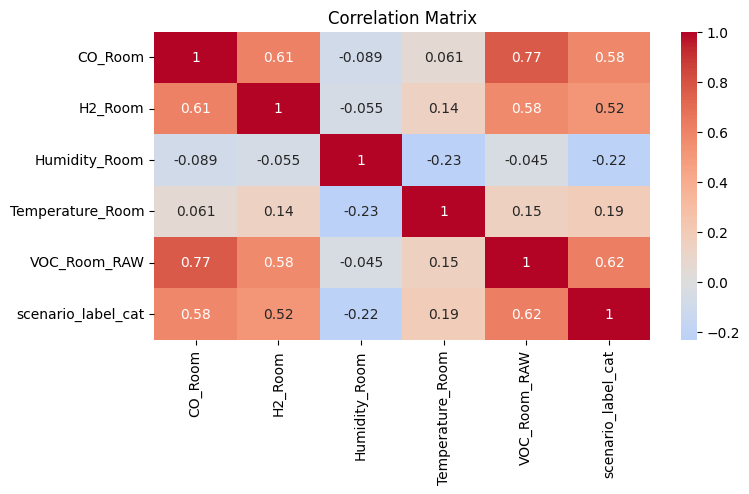

In [9]:
temp = data
corr_matrix = temp.drop('scenario_label',axis=1).corr()
plt.figure(figsize=(8,4))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### **Importing sklearn for the baseline models:**

A logistic regression classifier\
A decision tree classifier\
A kneighbors classifier

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

Splitting the dataset into training and testing splits with 80:20 ratio

In [11]:
from sklearn.model_selection import train_test_split
X = data.drop(['scenario_label_cat','scenario_label'],axis=1)
y = data['scenario_label_cat']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=21)

Training a logistic regression model with a combination of l1 and l2 regularization/penalty

In [12]:
log_reg = LogisticRegression(solver='saga',penalty='elasticnet',max_iter=500,l1_ratio=.5)
log_reg.fit(X_train,y_train)

C:\Users\Josh\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, max_iter=500, penalty='elasticnet',
                   solver='saga')

Testing the trained logistic regression model on the testing dataset

In [13]:
log_reg.score(X_test,y_test)

0.8855079346882626

Training a decision tree model

In [14]:
tree_clfr = DecisionTreeClassifier()
tree_clfr.fit(X_train,y_train)

DecisionTreeClassifier()

Testing the trained decision tree model on the testing dataset

In [15]:
tree_clfr.score(X_test,y_test)

0.9812318828712271

Training a k-neighbors model using 8 neighbors

In [16]:
knn_clfr = KNeighborsClassifier(n_neighbors=8)
knn_clfr.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=8)

Testing the trained k-neighbors model on the testing dataset

In [17]:
knn_clfr.score(X_test,y_test)

0.9819360966901951

### **Importing tensorflow for the neural network model**

In [18]:
import tensorflow as tf;
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Using a simple neural network with 3 fully connected inner layers\
with 64,128, and 256 units, all with relu activation\
The output layer is a fully connected layer with softmax activation 

In [19]:
n_classes = data['scenario_label'].nunique()

nn_clfr = Sequential([
    Dense(64,activation='relu',input_shape=[5]),
    Dense(128,activation='relu',),
    Dense(256,activation='relu'),
    Dense(n_classes,activation='softmax')]
)

C:\Users\Josh\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Getting a summary of the neural network's architecture

In [20]:
nn_clfr.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,784 (171.03 KB)

 Trainable params: 43,784 (171.03 KB)

 Non-trainable params: 0 (0.00 B)

Training the neural network for 25 iterations/epochs\
using sparse categorical cross entropy loss\
and the Adaptive Moment Estimation (Adam) optimizer

In [21]:
nn_clfr.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

nn_history = nn_clfr.fit(X_train,y_train,epochs=25,batch_size=64,validation_data=[X_test,y_test])

Epoch 1/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.8811 - loss: 0.4501 - val_accuracy: 0.9047 - val_loss: 0.3329
Epoch 2/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9020 - loss: 0.3236 - val_accuracy: 0.9058 - val_loss: 0.3050
Epoch 3/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.9077 - loss: 0.2922 - val_accuracy: 0.9098 - val_loss: 0.2785
Epoch 4/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9104 - loss: 0.2772 - val_accuracy: 0.9134 - val_loss: 0.2636
Epoch 5/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9126 - loss: 0.2643 - val_accuracy: 0.9165 - val_loss: 0.2473
Epoch 6/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9169 - loss: 0.2492 - val_accuracy: 0.9166 - val_loss: 0.2499
Epoch 7/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9193 - loss: 0.2397 - val_accuracy: 0.9201 - val_loss: 0.2364
Epoch 8/25
3817/3817 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9216 - loss: 0

In [22]:
nn_clfr.evaluate(X_test,y_test)

1909/1909 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9385 - loss: 0.1710


[0.17242200672626495, 0.9384549856185913]

### **Importing sklearn for the ensemble models**

In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,StackingClassifier
from xgboost import XGBClassifier

Using a bagging ensemble technique by training a random forest classifier with 50 decision trees

In [24]:
rf_clfr = RandomForestClassifier(n_estimators=50)
rf_clfr.fit(X_train,y_train)

RandomForestClassifier(n_estimators=50)

Testing the trained random forest classifier

In [25]:
rf_clfr.score(X_test,y_test)

0.9895678092399404

Using a boosting ensemble technique by training a gradient boosting classifier and extreme gradient boosting classifier

In [26]:
gb_clfr = GradientBoostingClassifier()
gb_clfr.fit(X_train,y_train)

xgb_clfr = XGBClassifier()
xgb_clfr.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Testing the trained gradient boosting classifier

In [27]:
gb_clfr.score(X_test,y_test)

0.9332634578536217

Testing the trained xgboost classifer

In [28]:
xgb_clfr.score(X_test,y_test)

0.9804130295933574

Using a stacking ensemble technique that trains multiple base models:\
--- a decision tree classifier and\
--- a k-neighbors classifier\
and then trains a logistic regression classifier to classify\
based on the predictions of the base models

In [29]:
stack_clfr = StackingClassifier(estimators=[
    ('decision_tree',DecisionTreeClassifier()),
    ('k_neighbors',KNeighborsClassifier()),
],final_estimator=LogisticRegression(max_iter=100),n_jobs=3)

stack_clfr.fit(X_train,y_train)

StackingClassifier(estimators=[('decision_tree', DecisionTreeClassifier()),
                               ('k_neighbors', KNeighborsClassifier())],
                   final_estimator=LogisticRegression(), n_jobs=3)

Testing the trained stacking classifier 

In [30]:
stack_clfr.score(X_test,y_test)

0.9880283650775454

### **Visualizing the decision tree model**

In [31]:
from sklearn import tree

In [32]:
tree.export_graphviz(tree_clfr,
                     out_file='decision_tree_viz.dot',
                     feature_names=['CO_Room','H2_Room','Humidity_Room','Temperature_Room','VOC_Room_RAW'],
                     class_names=sorted(data['scenario_label'].unique()),
                     label='all',
                     rounded=True,
                     filled=True
                     )

### **Saving all the models**

In [33]:
import joblib

In [34]:
joblib.dump(log_reg,'logistic_regression.pkl')
joblib.dump(tree_clfr,'decision_tree.pkl')
joblib.dump(knn_clfr,'k_neighbors.pkl')
joblib.dump(rf_clfr,'random_forest.pkl')
joblib.dump(gb_clfr,'gradient_boost.pkl')
joblib.dump(xgb_clfr,'x_gradient_boost.pkl')
joblib.dump(stack_clfr,'stacking.pkl')
nn_clfr.save('neural_network.keras')

### **Accuracy Metrics**
Logistic Regression : 0.8855079346882626\
Decision Tree : 0.9813301452645715\
KNeighbors : 0.9819360966901951\
Random Forest : 0.9892075137976777\
Gradient Boosting : 0.9332470807880644\
Extreme Gradient Boosting : 0.9804130295933574\
Stacking : 0.9878154632252993\
Neural Network : 0.9380619525909424